# Dynamics of Specialization

In this example, we will implement  2-module modular architectures from https://arxiv.org/abs/2106.02626

We examine 5 levels of structural modularity $Q$, by changing the amount of interconnection $p$ present between module, as well as 3 different module sizes $n$

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from functools import partial
import copy
from tqdm.notebook import tqdm
import matplotlib

In [2]:
%load_ext autoreload
%autoreload 2

## Data

### Generate

We generate double-MNIST data, suited for a 2-module modular architecture

In [3]:
from dynspec.datasets import get_datasets
from dynspec.data_process import process_data
from dynspec.tasks import get_task_target
from dynspec.decision import get_decision

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
n_modules = 2
n_classes_per_digit = 10
n_classes = n_classes_per_digit * n_modules
nb_steps = 5

data_config = {
    # ------ Change if needed------
    "batch_size": 256,
    "input_size": 28,
    "use_cuda": use_cuda,
    "data_type": "double_digits",
    "n_digits": n_modules,
    "n_classes": n_classes,
    "n_classes_per_digit": n_classes_per_digit,
    "nb_steps": nb_steps,
    # cov ratio : controls the probabilty of seeing D1 == D2, default = 1 (chance probability)
    "cov_ratio": 1,
    # noise ratio : controls the ammount of noise added to the input , default = 0.4
    "noise_ratio": 0.4,
    # random start : add stochasticity by having input start at random times from pure noise, default = False
    "random_start": False,
    # --------------------------
}

In [6]:
all_data = get_datasets("../data/", data_config)
datasets, loaders = all_data[data_config["data_type"]]
len(datasets[0])

60000

### Plot

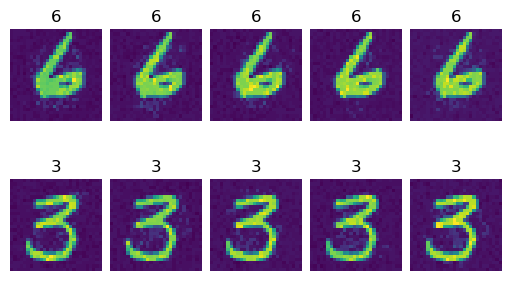

In [7]:
data, target = next(iter(loaders[0]))

temporal_data, _ = process_data(data, data_config)
temporal_data = torch.stack(
    temporal_data.split(temporal_data.shape[-1] // n_modules, -1), 1
)

fig, axs = plt.subplots(
    n_modules, temporal_data.shape[0], constrained_layout=True, figsize=(5, 3)
)
for t_data, t_axs in zip(temporal_data, axs.T):
    for d, ax, t in zip(t_data, t_axs, target[0].cpu().numpy()):
        ax.imshow(d[0].cpu().numpy().reshape(28, 28))
        ax.axis("off")
        ax.set_title(t)

## Init Models

Initialization of models with varying ammount of structural modularity

In [8]:
from dynspec.models import Community, init_model
from torch.nn import RNN, GRU, RNNCell, GRUCell
from dynspec.plotting import plot_model_masks
import pandas as pd
from dynspec.training import train_community, get_acc, get_loss
from dynspec.experiment import Experiment

In [9]:
# feel free to try other tasks, such as 'sum' or 'bitxor'
task = "parity-digits-both"
# task = 'sum'

modules_config = {
    "n_modules": 2,
    "hidden_size": None,  # will be changed later
    "n_layers": 1,
    "dropout": 0.0,
    "cell_type": str(RNN),
}
connections_config = {"sparsity": None}  # Will be changed later
input_config = {"input_size": data_config["input_size"] ** 2, "common_input": False}
optim_config = {"lr": 1e-3, "weight_decay": 1e-5}
readout_config = {"common_readout": False}
decision = ["last", "max"]
training_config = {"n_epochs": 30, "task": task}

default_config = {
    "modules": modules_config,
    "connections": connections_config,
    "input": input_config,
    "readout": readout_config,
    "data": data_config,
    "decision": decision,
    "training": training_config,
    "optim": optim_config,
}

In [12]:
# We look at networks of 1 or 3 different sizes and 5 sparsity levels
n_hiddens = [25]
# n_hiddens = [10, 25, 50]
# Negative values for the sparsity field directly specify number of connections (irrelevant of the hidden size) : eg -1 means exactly 1 connection
sparsities = [-1, 1e-2, 1e-1, 0.5, 1.0]
varying_params = {"hidden_size": n_hiddens, "sparsity": sparsities}

In [13]:
# Save yourself some training time by pre-loading the results, or check out training by yourself. On a gpu, it should take about 5 minutes per model (for 30 epochs)
experiment = Experiment(
    default_config, varying_params, load_save=True, n_tests=1, device=device
)

results/pre-loaded-examples/3badd03f80f848be6764d0ca0f6b508784bae994
Results loaded


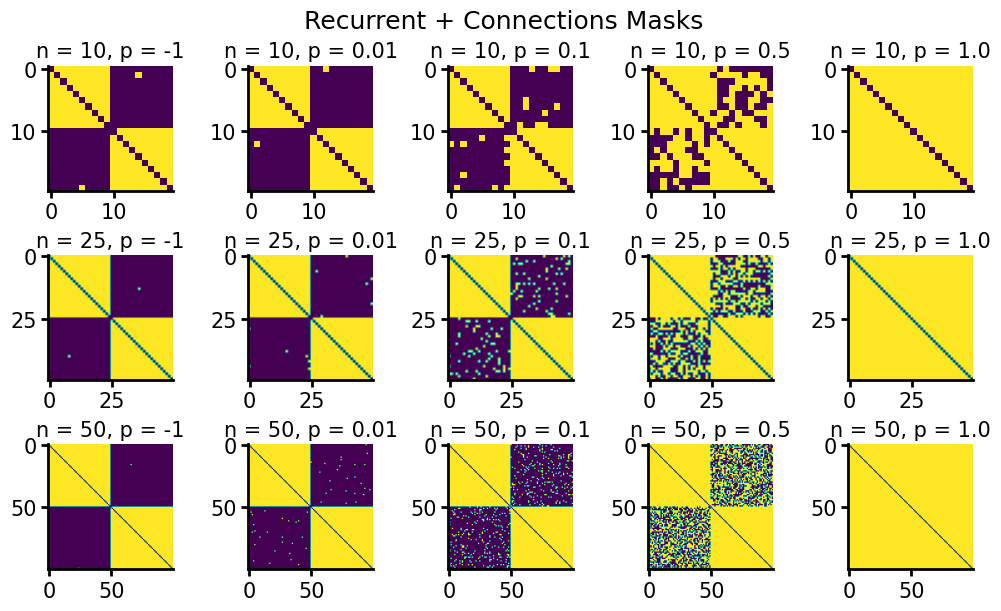

In [281]:
# plot the reccurent connections of the models, this changes depending on the sparsity of intereconnections
plot_model_masks(experiment, plot_input=False)

## Training

In [282]:
if not experiment.loaded:
    experiment.run(loaders, save=True)

### Results

In [283]:
from dynspec.plotting import plot_accs

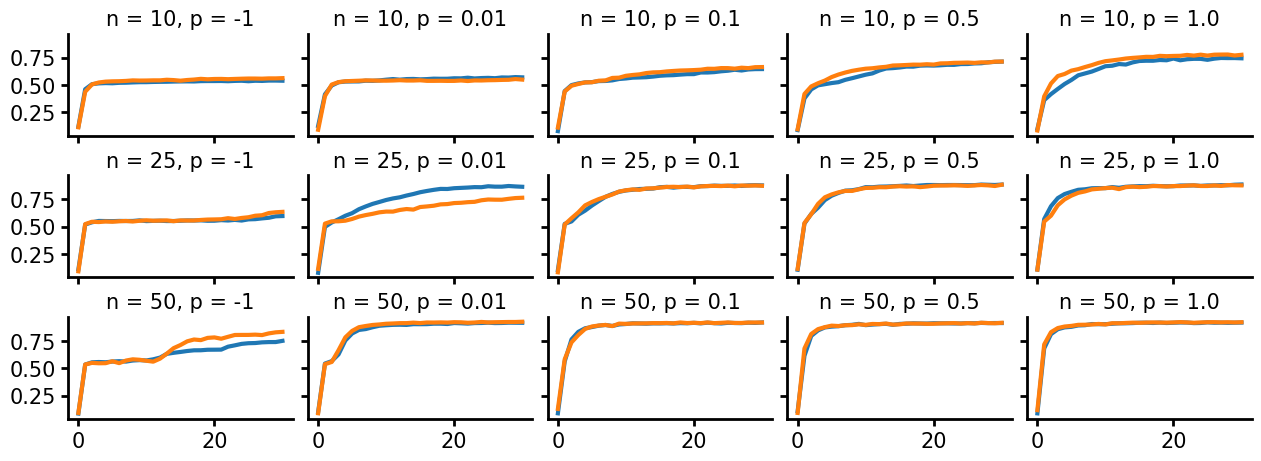

In [284]:
plot_accs(experiment)

## Metrics

In [285]:
from dynspec.plotting import plot_metric_results

### Retraining

In [286]:
if (not experiment.loaded) or (experiment.retrained_models is None):
    experiment.compute_retraining(loaders, save=True)

### Correlations

In [287]:
from dynspec.correlations import fixed_information_data

#### Plot modified data for correlations
The idea here is to look at autocorrelation of hidden states, when only one digit is varying and the other is fixed.

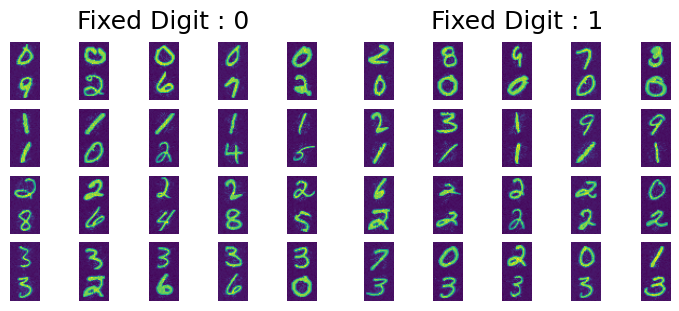

In [288]:
data, target = next(iter(loaders[0]))
data = process_data(data, data_config)[0]
fig = plt.figure(figsize=(7, 3), constrained_layout=True)
subfigs = fig.subfigures(1, 2)
for fixed, subfig in enumerate(subfigs):
    f_datas = fixed_information_data(data, target, fixed=fixed)
    axs = subfig.subplots(len(f_datas[:4]), nb_steps)
    subfig.suptitle(f"Fixed Digit : {fixed}")
    for axs_t, f_d in zip(axs, f_datas):
        [ax.imshow(d[i].reshape(2*28, 28)) for i, (ax, d) in enumerate(zip(axs_t, f_d))]
        [ax.axis("off") for ax in axs_t]

In [289]:
if (not experiment.loaded) or (not 'correlations' in experiment.results.columns):
    experiment.compute_correlations(loaders, save=True)

### Ablations

In [290]:
if (not experiment.loaded) or (not 'ablations' in experiment.results.columns):
    experiment.compute_ablations(loaders, save=True)

## Plot Results

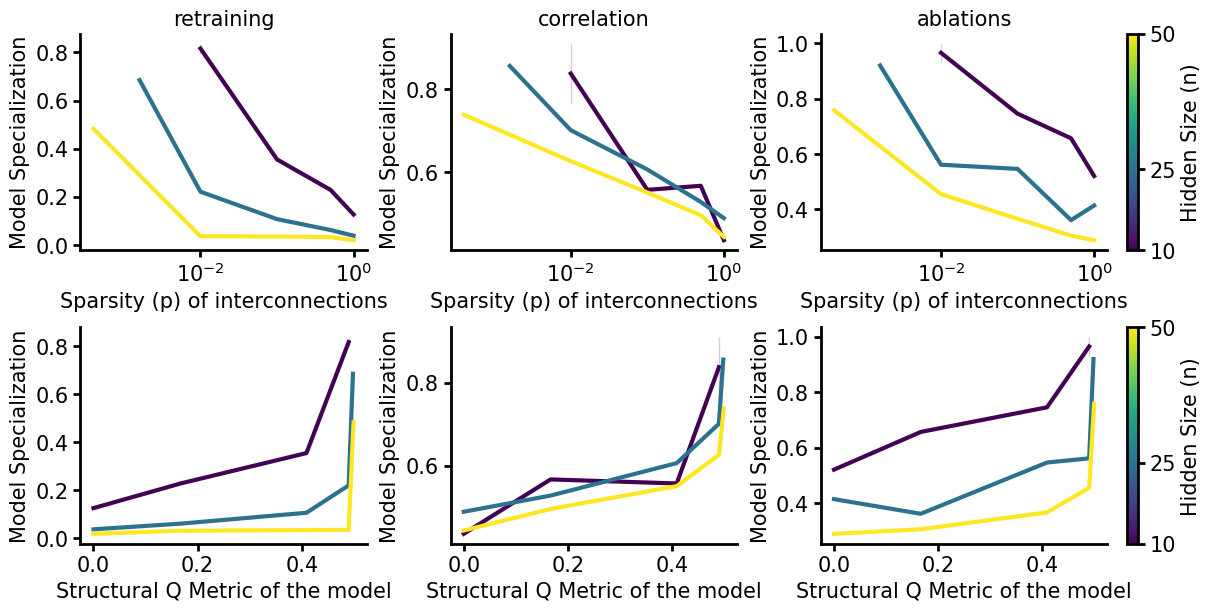

In [291]:
metric_data = plot_metric_results(experiment)

### Random Timings

In [292]:
from dynspec.plotting import plot_random_timings
from dynspec.retraining import diff_metric, metric_norm_acc

In [293]:
experiment.compute_random_timing(loaders)

  0%|          | 0/15 [00:00<?, ?it/s]

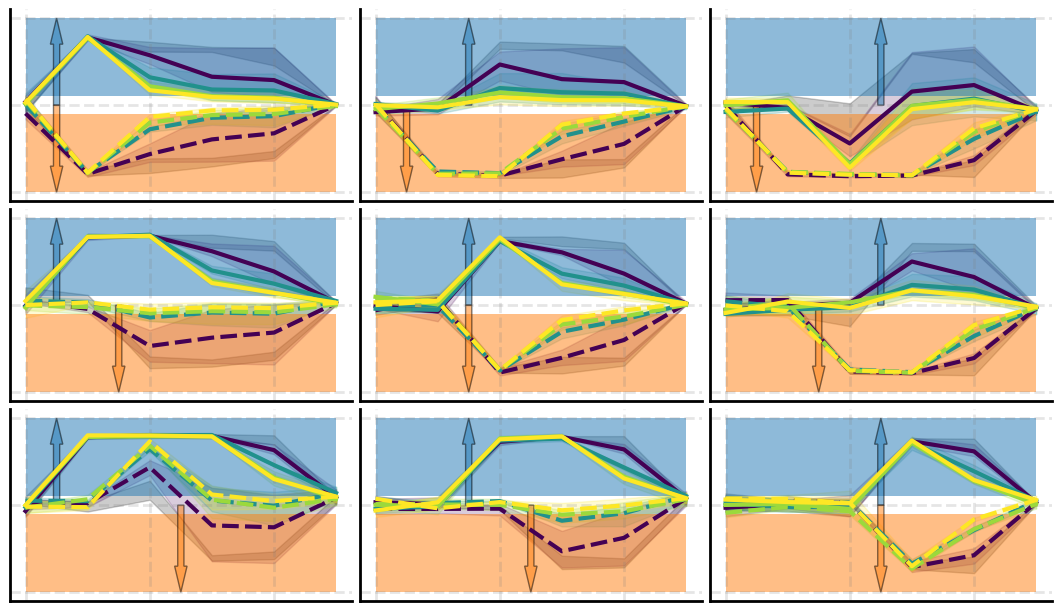

In [294]:
plot_data = plot_random_timings(experiment)